# <center> CHE1147 Programming Assignment 5 <center>

#### <center> Yunjie Xu 1008601951<center> 

In [1]:
import pandas as pd 
import  numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score
import  matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

## 1 Supervised learning
### 1.1 Import the monthly and annual data and join

In [2]:
#read kaggle data
kaggle = pd.read_csv('Retail_Data_Response.csv')
kaggle.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [3]:
#create annual features
annual_features = pd.read_excel('annual_features.xlsx')

annual_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')

annual_features_outputs = pd.merge(annual_features, 
                                   annual_pivot, on = 'customer_id').merge(kaggle, on = 'customer_id')
annual_features_outputs.head()

,customer_id,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,...,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday,response
0,CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,...,1,1,0,0,0,0,0,0,1,0
1,CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,...,3,0,0,2,0,0,0,0,1,0
2,CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,...,1,1,0,0,0,0,1,0,0,1
3,CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,...,0,2,0,0,0,0,1,0,0,1
4,CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,...,0,0,0,0,0,0,0,0,0,1


In [4]:
#create monthly features
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

day_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

mth_features_outputs = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(kaggle.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_outputs.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,-5,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0


### 1.2 Steps for each method (10 points)

>**1.** Separate the inputs X and the output y in two data frames.

In [5]:
# the inputs X 
X_annual = annual_features_outputs.drop(['customer_id', 'response'], axis = 1)
X_annual.head()

,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,1,...,1,1,1,0,0,0,0,0,0,1
1,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,3,...,0,3,0,0,2,0,0,0,0,1
2,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,1,...,0,1,1,0,0,0,0,1,0,0
3,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,1,...,2,0,2,0,0,0,0,1,0,0
4,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# the output y
y_annual = annual_features_outputs['response']
y_annual.head()

0    0
1    0
2    1
3    1
4    1
Name: response, dtype: int64

> **2.** Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value). Use the following names for consistency.

In [7]:
# annual 
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, 
                                                                                test_size=2/3, 
                                                                                random_state=1147)

In [8]:
X_train_annual.head()

,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
1556,88.000000,75.000000,64.857143,84.400000,0.0,2,5,7,5,0,...,4,0,0,0,0,0,0,0,0,0
3472,103.000000,58.600000,76.200000,53.428571,0.0,1,5,5,7,0,...,2,0,0,0,0,0,0,0,0,0
4344,73.142857,82.333333,71.333333,55.500000,72.0,7,3,3,4,1,...,1,0,1,0,0,0,0,0,1,0
1707,65.250000,72.200000,60.200000,62.500000,82.5,4,5,5,4,2,...,1,2,0,1,0,1,0,0,0,0
3561,68.000000,73.500000,70.000000,59.500000,82.0,6,4,7,2,1,...,0,0,0,1,0,0,0,0,0,0


In [9]:
y_train_annual.head()

1556    0
3472    0
4344    0
1707    0
3561    0
Name: response, dtype: int64

> **3.** Pre-process (if necessary for the method).

In [10]:
scaler_annual = StandardScaler()

In [11]:
X_train_annual_scaled = scaler_annual.fit_transform(X_train_annual)
X_test_annual_scaled = scaler_annual.transform(X_test_annual)
X_train_annual_scaled,X_test_annual_scaled

(array([[ 1.26610112,  0.75251339,  0.17332356, ..., -0.37462899,
         -0.38350696, -0.37195027],
        [ 1.92746757, -0.2291989 ,  0.83149115, ..., -0.37462899,
         -0.38350696, -0.37195027],
        [ 0.61103338,  1.19149043,  0.54910354, ..., -0.37462899,
          2.25842987, -0.37195027],
        ...,
        [ 0.35488511,  1.04433335,  0.70383648, ..., -0.37462899,
          2.25842987,  2.30282691],
        [ 0.35121085,  1.35111844, -0.39863569, ..., -0.37462899,
          2.25842987, -0.37195027],
        [-0.62981607,  0.85228089,  0.55877435, ..., -0.37462899,
         -0.38350696, -0.37195027]]),
 array([[-0.52399743, -1.37253456, -1.13845254, ..., -0.37462899,
         -0.38350696, -0.37195027],
        [ 0.42837027,  0.56095977,  0.21062525, ..., -0.37462899,
         -0.38350696, -0.37195027],
        [ 0.63118932, -0.46179973,  0.07523393, ..., -0.37462899,
         -0.38350696, -0.37195027],
        ...,
        [ 0.31079401,  0.58148337, -0.03598037, ...,  

> **4.** Fit the training dataset and optimize the hyperparameters of the method.

In [12]:
lr = LogisticRegression(penalty ='l1', 
                        solver = 'liblinear', 
                        random_state=1147)

In [13]:
# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(lr, 
                    {'C':[0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}, 
                    scoring='f1', 
                    cv=10, 
                    n_jobs=-1)

grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_

print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

Best f1: 0.13692277287929464
The best parameter: {'C': 0.01}


In [14]:
# fit model on the training dataset
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)

lr.fit(X_train_annual, y_train_annual)

LogisticRegression(C=0.01, penalty='l1', random_state=1147, solver='liblinear')

In [15]:

def find_best_lr(X_train, y_train, X_test, y_test):
    
    Cs = [0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10]
    estimator_c, acc_train, acc_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]
    for i in range(len(Cs)):
        
        # Define and fit
        c = Cs[i]
        estimator_c.append(LogisticRegression(penalty='l1', C = c, solver='liblinear',class_weight='balanced',random_state=1147))
        estimator_c[i].fit(X_train, y_train)

        # Score train and test set
        scores_train = estimator_c[i].predict_proba(X_train)[:,1] 
        scores_test  = estimator_c[i].predict_proba(X_test)[:,1]  

        # Predict the class of training and test set
        y_train_predicted = estimator_c[i].predict(X_train)
        y_test_predicted = estimator_c[i].predict(X_test)
  
        # Calculate training and test accuracy at every iteration and append
        acc_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        acc_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
     
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))
     
        # Calculate precision and recall for test set
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
    
        # ROC Calc for training and test set
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
        # Generate a summary table for all metrics
        performance_dictionary = {'ACCURACY_TRAIN': acc_train, 
                                  'ACCURACY_TEST': acc_test, 
                                  'F1_TRAIN': f1_train, 
                                  'F1_TEST': f1_test, 
                                  'PRECISION': precisions, 
                                  'RECALL': recalls, 
                                  'AUC_TRAIN': auc_train, 
                                  'AUC_TEST': auc_test}
        
        performance_df = pd.DataFrame(performance_dictionary)

    performance_df.insert(0, 'C', value = Cs)
    return performance_df

In [16]:
lr_performance_annual = find_best_lr(X_train_annual_scaled, y_train_annual, X_test_annual_scaled, y_test_annual)

>**5.** Plot coefficient values or feature importance.


In [17]:
def plot_train_test_curves(performance_df, x_name):
 
    fig_1 = plt.figure(figsize=(24,7))
    
    fig_1_a = plt.subplot(131)
    ax1 = performance_df.plot(x = x_name, y = 'ACCURACY_TRAIN', ax = fig_1_a, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'ACCURACY_TEST', ax = fig_1_a, style = 'o-', markersize =7)
    ax1.set_xlabel("Hyperparameter: %s" % x_name)
    ax1.set_ylabel("Normalized Accuracy (%)")

     
    fig_1_b = plt.subplot(132)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =7)
    ax2.set_xlabel("Hyperparameter: %s" % x_name)
    ax2.set_ylabel("Area Under the Curve (AUC)")
     
    fig_1_c = plt.subplot(133)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TRAIN', ax = fig_1_c, style = 'o-', markersize =7)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TEST', ax = fig_1_c, style = 'o-', markersize =7)
    ax3.set_xlabel("Hyperparameter: %s" % x_name)
    ax3.set_ylabel("F1 Score")
     
    plt.show()

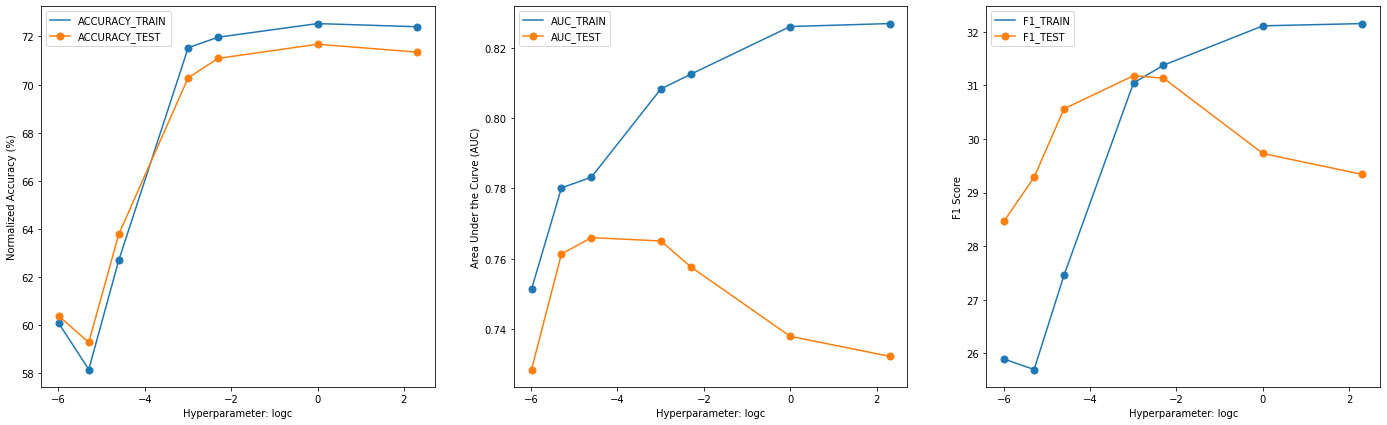

In [18]:
lr_performance_annual['logc'] = np.log(lr_performance_annual['C'])
plot_train_test_curves(lr_performance_annual,'logc')

In [19]:
lr_performance_annual

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,logc
0,0.0025,60.069747,60.370370,25.889968,28.470311,0.173040,0.802661,0.751271,0.728438,-5.991465
1,0.0050,58.151700,59.281046,25.696594,29.284904,0.176551,0.858093,0.780110,0.761302,-5.298317
2,0.0100,62.685266,63.769063,27.457627,30.563674,0.188272,0.811530,0.783154,0.765955,-4.605170
3,0.0500,71.534438,70.283224,31.045407,31.180626,0.201829,0.685144,0.808258,0.765016,-2.995732
4,0.1000,71.970357,71.089325,31.376734,31.136482,0.203252,0.665188,0.812457,0.757648,-2.302585
5,1.0000,72.537053,71.677560,32.112069,29.729730,0.196569,0.609756,0.826030,0.737881,0.000000
6,10.0000,72.406277,71.350763,32.154341,29.339065,0.193617,0.605322,0.826869,0.732205,2.302585


    The accuracy curves make it abundantly evident that accuracy is comparatively higher when C >= 0.05. The F1 score for the test set is greater and the AUC score is comparatively higher when C=0.1, according to AUC curves and F1 scores for both the training and test datasets. As a result, I decided that the best C for this logistic regression model would be 0.1.

In [20]:

def lr(X_train, X_test, y_train, y_test, X, best_param):
    
    '''Using the best hyperparamter C for logistic regression and plot the feature coefficients (sorted)
    Attributes: 
        X_train: training dataset
        y_train: ground truth of the training data
        X_test: test dataset
        y_test: ground truth of the test data
        X: original trainig dataset with columns names (for plotting feature importance)
        best_param: best C got from above
    Return:
        best_model: a logistic regression model with the best hyperparameter after fitting
        y_test_pred: predictions from test dataset
        y_test_prob: predicted probabilities for test dataset
        scores_train: predicted probabilities of class 1 from training dataset
        scores_test: predicted probabilities of class 1 from test dataset
    '''
    
    best_model = LogisticRegression(penalty='l1',solver='liblinear', C=best_param, class_weight='balanced',random_state=1147)
    best_model.fit(X_train, y_train)
    m = best_model.coef_
    
    indices = np.argsort(abs(m[0]))[::-1]
    names = [X.columns[i] for i in indices]
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]} ')
 
    #plot coefficient values 
    plt.figure(figsize=(16,5)) 
    plt.bar(range(X.shape[1]), m[0])
    plt.title("Coefficient values")
    plt.xticks(range(X.shape[1]), X.columns, rotation=90,size=7)
    plt.show()
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
   
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1]
    scores_test = best_model.predict_proba(X_test)[:, 1] 
        
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 8:ann_txn_amt_cnt_2014, 32:ann_txn_amt_sum_2013 


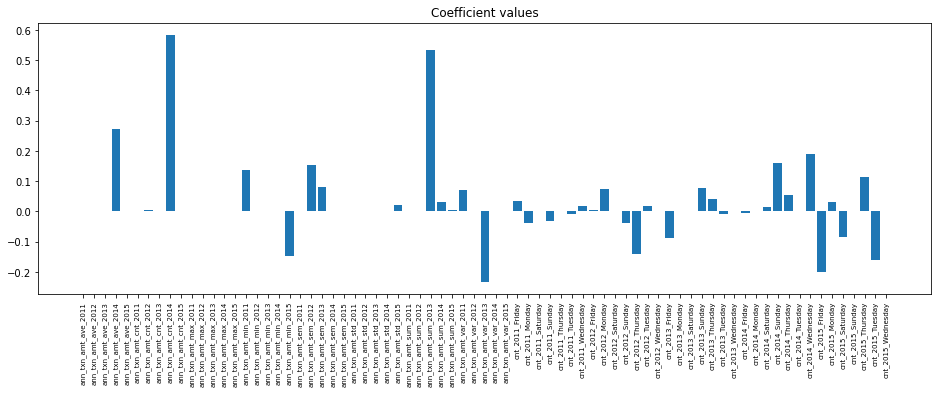

In [21]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, X_train_annual, 0.1)

> **6.** Plot probability distribution for test set.


<Figure size 720x576 with 0 Axes>

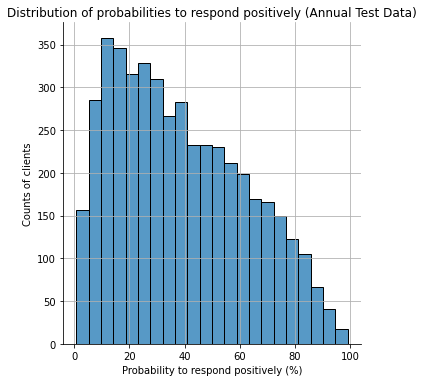

In [22]:
fig = plt.figure(figsize= (10,8))
sns.displot(data = y_test_prob[:,1], x = 100 * y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively (Annual Test Data)')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.grid()
plt.show()

> **7.** Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.


In [23]:
def plot_confusion_matrix(y_test, y_test_predicted):
 
    cm = confusion_matrix(y_test, y_test_predicted)
 
    precision = cm[1,1]/cm.sum(axis=0)[1]
    recall = cm[1,1]/cm.sum(axis=1)[1]
 
    print('Precision:', precision)
    print('Recall', recall)
    
    fig = plt.figure(figsize= (8,8))
    classNames = ['Negative','Positive']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

Precision: 0.2032520325203252
Recall 0.6651884700665188


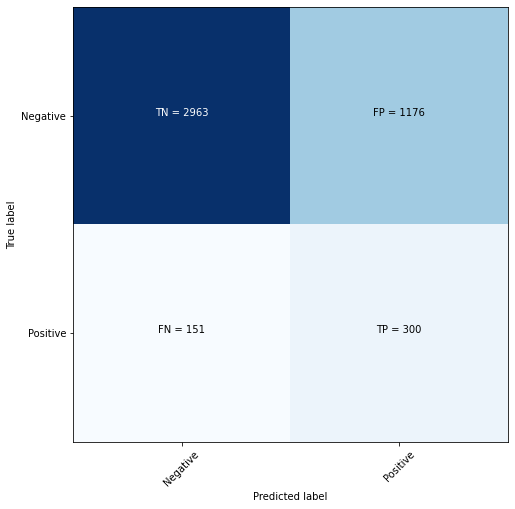

In [24]:
plot_confusion_matrix(y_test_annual.values, y_test_pred)

In [25]:
def plot_roc(y_train, scores_train, y_test, scores_test, model_name):
 
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test  = auc(fpr_test, tpr_test)
 
    # Plotting
    fig = plt.figure(figsize= (10,8))
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test))
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('{} ROC curves'.format(model_name))
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()
    plt.grid()

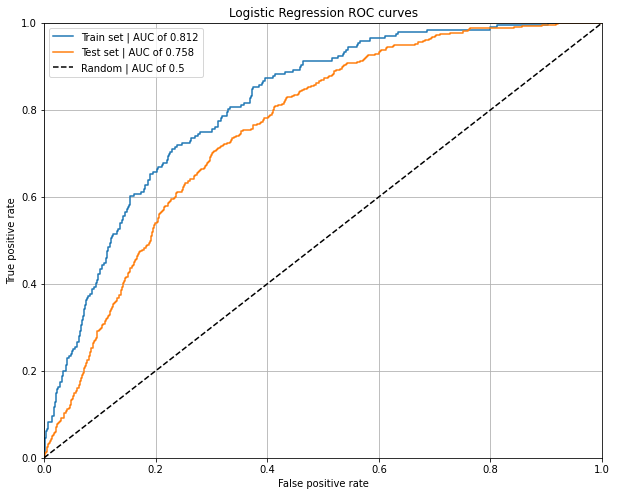

In [26]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Logistic Regression')

In [27]:
def plot_decision_boundary(best_model, feat1, feat2, X_train_scaled, X, y_train):
    #print('Top 2 features are:',X.columns[[feat1, feat2]])
    min_value1, min_value2 = np.floor(X_train_scaled.min(axis=0)[[feat1, feat2]])
    max_value1, max_value2 = np.ceil(X_train_scaled.max(axis=0)[[feat1, feat2]])

    step1, step2 = (max_value1-min_value1)/10, (max_value2-min_value2)/10
    xx, yy = np.mgrid[min_value1:max_value1:step1, min_value2:max_value2:step2]
    grid = np.c_[xx.ravel(), yy.ravel()]
    median_inputs = np.ones((100, X.shape[1])) * np.median(X_train_scaled, axis=0)
    median_inputs[:,feat1] = grid[:,0]
    median_inputs[:,feat2] = grid[:,1]
 
    probs = best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
 
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    ax.scatter(X_train_scaled[50:,feat1], X_train_scaled[50:,feat2], c=y_train[50:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
 
    ax.set(aspect="auto", xlim=(min_value1, max_value1), ylim=(min_value2, max_value2),
           xlabel=f"{X.columns[feat1]}", ylabel=f"{X.columns[feat2]}")

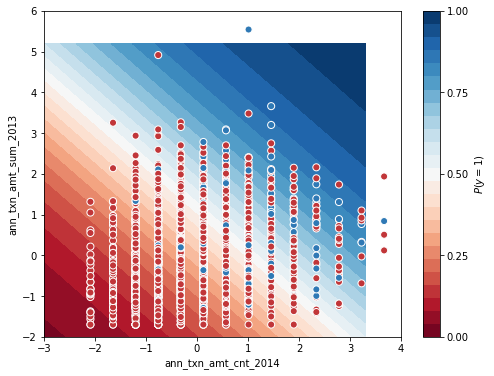

In [28]:
plot_decision_boundary(best_model, 8, 32, X_train_annual_scaled, X_train_annual, y_train_annual)


### Decision Tree

In [29]:
def find_best_dt(X_train, y_train, X_test, y_test): 

    max_depth_range = range(2, 11) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for i in max_depth_range: 
        # Define and fit\n",
        estimator_max_depth.append(DecisionTreeClassifier(max_depth = i, random_state=1147, class_weight='balanced')) 
        estimator_max_depth[i-2].fit(X_train, y_train) 
 
        # Score train and test set  
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
 
        # Predict the class of train and test set 
        y_train_predicted = estimator_max_depth[i-2].predict(X_train) 
        y_test_predicted = estimator_max_depth[i-2].predict(X_test) 
 
        # Calculate training and test accuracy at every iteration and append 
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True)) 
 
        # Calculate training and test F1 score at every iteration and append 
        f1_train.append(100*f1_score(y_train, y_train_predicted)) 
        f1_test.append(100*f1_score(y_test, y_test_predicted)) 
 
        # Calculate precision and recall 
        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        # ROC Calc Train and test set  
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train) 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test) 
 
        # Calculate the AUCs 
        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train,  
                              'ACCURACY_TEST': accuracy_test, 
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df.insert(0, 'MAX_DEPTH', value = max_depth_range ) 
    return performance_df


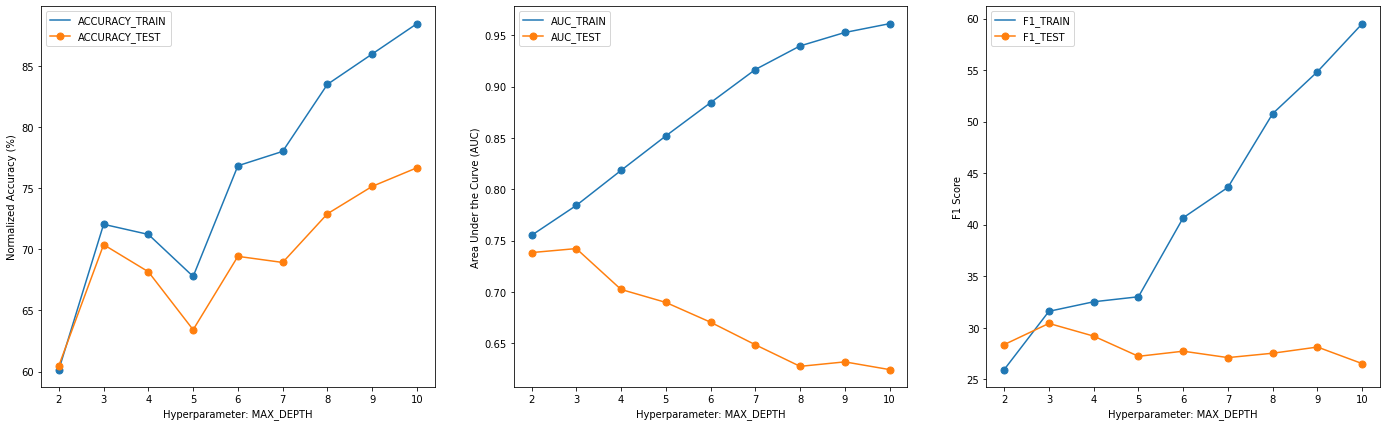

In [30]:
dt_performance_annual = find_best_dt(X_train_annual, y_train_annual, X_test_annual, y_test_annual)
plot_train_test_curves(dt_performance_annual,'MAX_DEPTH')

In [31]:
dt_performance_annual

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.156931,60.479303,25.931929,28.357030,0.172513,0.796009,0.755100,0.738316
1,3,72.057541,70.392157,31.590181,30.414747,0.197736,0.658537,0.784239,0.742226
2,4,71.229294,68.169935,32.515337,29.180805,0.186725,0.667406,0.818369,0.702421
3,5,67.785527,63.420479,33.000907,27.221500,0.169181,0.696231,0.851948,0.689792
4,6,76.852659,69.433551,40.670391,27.717671,0.180537,0.596452,0.884363,0.670500
5,7,78.029643,68.932462,43.624161,27.096115,0.176080,0.587583,0.916638,0.648549
6,8,83.522232,72.919390,50.781250,27.521866,0.186709,0.523282,0.939633,0.627504
7,9,86.006975,75.163399,54.852321,28.121059,0.196476,0.494457,0.952722,0.631862
8,10,88.491718,76.688453,59.509202,26.510989,0.192040,0.427938,0.961312,0.624342



    According to test results for AUC and F1, the test results for AUC and F1 both peak when max depth is 3. Thus, I decide on max depth = 3.

In [32]:
def dt(X_train, X_test, y_train, y_test, X, best_param): 
 
    best_model = DecisionTreeClassifier(max_depth=best_param, random_state=0, class_weight='balanced') 
    best_model.fit(X_train, y_train) 
    importances = best_model.feature_importances_ 
    
    indices = np.argsort(abs(importances))[::-1]
    names = [X.columns[i] for i in indices]
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]} ')
 
    names = [X.columns[i] for i in indices] 
    plt.figure(figsize=(16,5)) 
    plt.title("Feature Importance") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation=90) 
    plt.show()
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
 
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1] 
    scores_test = best_model.predict_proba(X_test)[:, 1] 
 
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 33:ann_txn_amt_sum_2014, 32:ann_txn_amt_sum_2013 


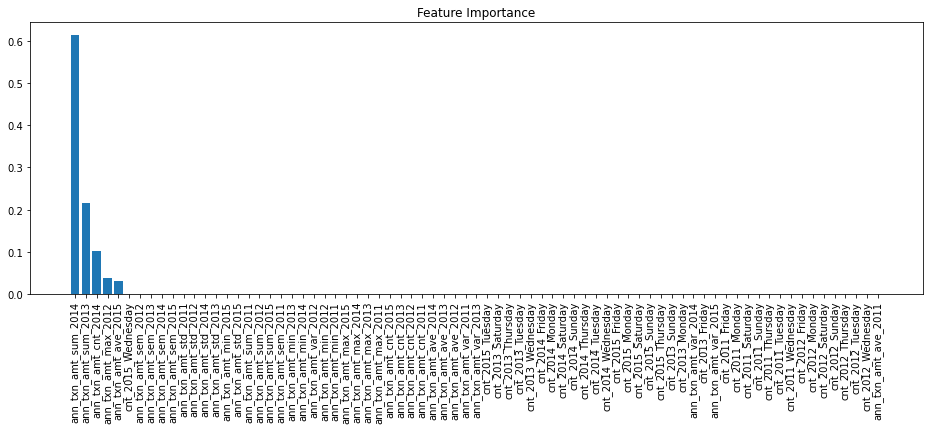

In [33]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_annual, X_test_annual, y_train_annual, y_test_annual, X_train_annual,3)

<Figure size 720x576 with 0 Axes>

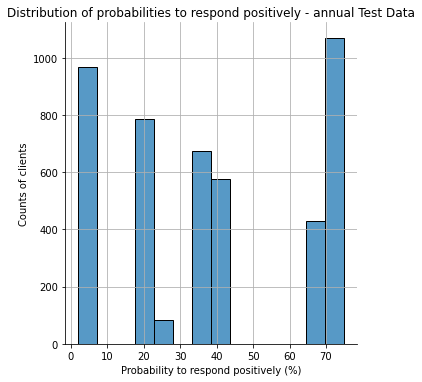

In [34]:
fig = plt.figure(figsize= (10,8))
sns.displot(data = y_test_prob[:,1], x = 100*y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively - annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.grid()
plt.show()

Precision: 0.1977363515312916
Recall 0.6585365853658537


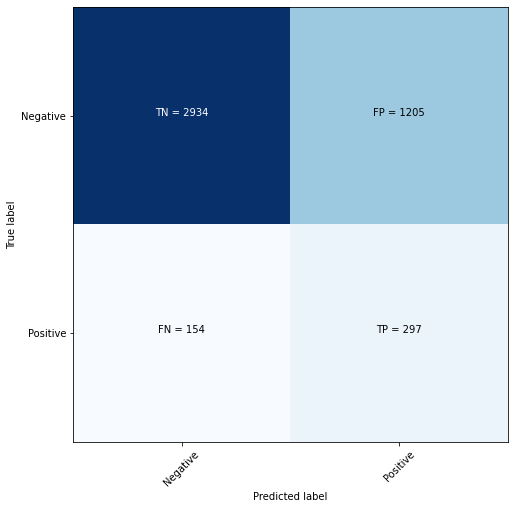

In [35]:
plot_confusion_matrix(y_test_annual.values, y_test_pred)

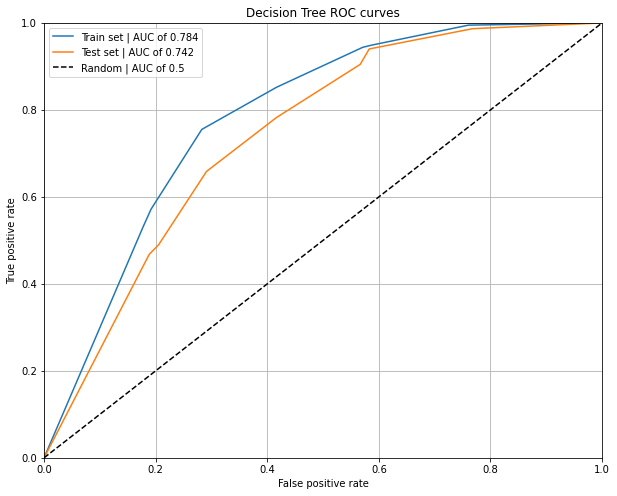

In [36]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Decision Tree')

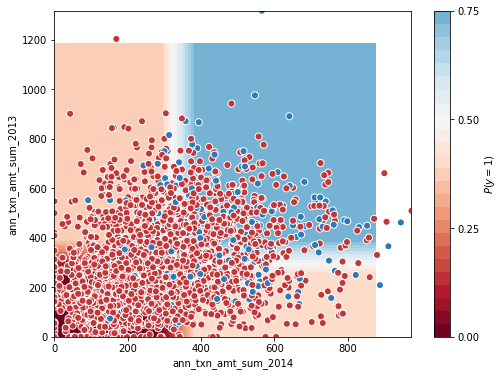

In [37]:
plot_decision_boundary(best_model, 33, 32, X_train_annual.values, X_train_annual, y_train_annual)

### Random Forest

In [38]:
def find_best_rf(X_train, y_train, X_test, y_test): 
 
    max_depth_range = range(2,20) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for i in max_depth_range: 
        # Define and fit 
        estimator_max_depth.append(RandomForestClassifier(max_depth = i,class_weight='balanced', random_state=1147)) 
        estimator_max_depth[i-2].fit(X_train, y_train) 
 
        # Score train and test set 
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1] 
 
        # Predict the class of test set 
        y_train_predicted = estimator_max_depth[i-2].predict(X_train) 
        y_test_predicted = estimator_max_depth[i-2].predict(X_test) 
 
        # Calculate training and test accuracy at every iteration and append 
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True)) 
 
        # Calculate training and test F1 score at every iteration and append 
        f1_train.append(100*f1_score(y_train, y_train_predicted)) 
        f1_test.append(100*f1_score(y_test, y_test_predicted)) 
 
        # Calculate precision and recall 
        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        # ROC Calc trianing and test dataset 
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train) 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test) 
 
        # Calculate the AUCs 
        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test,  
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    performance_df = pd.DataFrame(performance_dictionary) 
    performance_df.insert(0, 'MAX_DEPTH', value = max_depth_range)  
    return performance_df

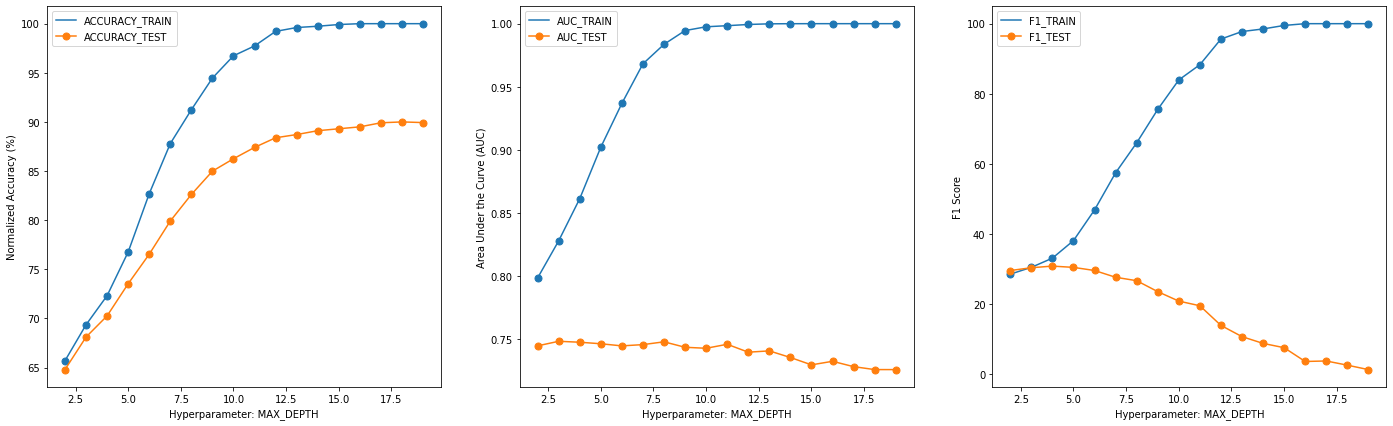

In [39]:
rf_performance_annual = find_best_rf(X_train_annual, y_train_annual, X_test_annual, y_test_annual)
plot_train_test_curves(rf_performance_annual,'MAX_DEPTH')

In [40]:
rf_performance_annual

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,65.693112,64.793028,28.519528,29.555362,0.183939,0.751663,0.798662,0.744882
1,3,69.354839,68.104575,30.464886,30.352046,0.193216,0.707317,0.828058,0.748484
2,4,72.319093,70.261438,33.087460,30.816016,0.199737,0.674058,0.861469,0.747739
3,5,76.765475,73.529412,38.095238,30.452204,0.205247,0.589800,0.902222,0.746528
4,6,82.693984,76.535948,46.854083,29.561805,0.209647,0.501109,0.936886,0.744844
5,7,87.794246,79.912854,57.446809,27.629513,0.213852,0.390244,0.968206,0.745854
6,8,91.238012,82.614379,65.989848,26.654412,0.227630,0.321508,0.983648,0.748060
7,9,94.463819,84.989107,75.529865,23.529412,0.235556,0.235033,0.994540,0.743742
8,10,96.730602,86.252723,83.940043,20.828105,0.239884,0.184035,0.997541,0.742950
9,11,97.733217,87.407407,88.288288,19.498607,0.262172,0.155211,0.998400,0.746119


    With an increase in max depth, accuracy rises. Auc curve essentially stays the same. F1 scores tend to be higher when max depth is between 3 and 5. Therefore, I decide on max depth = 5 based on the accuracy and F1 score.

In [41]:
def rf(X_train, X_test, y_train, y_test, X,best_param): 
 
    best_model = RandomForestClassifier(max_depth = best_param, random_state=1147, class_weight='balanced') 
    best_model.fit(X_train, y_train) 
 
    #plot feature importance 
    importances = best_model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    names = [X.columns[i] for i in indices] 
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]}')
    plt.figure(figsize=(16,5)) 
    plt.title("Feature Importance") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation=90) 
    plt.show() 
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
 
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1] 
    scores_test = best_model.predict_proba(X_test)[:, 1] 
 
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 33:ann_txn_amt_sum_2014, 8:ann_txn_amt_cnt_2014


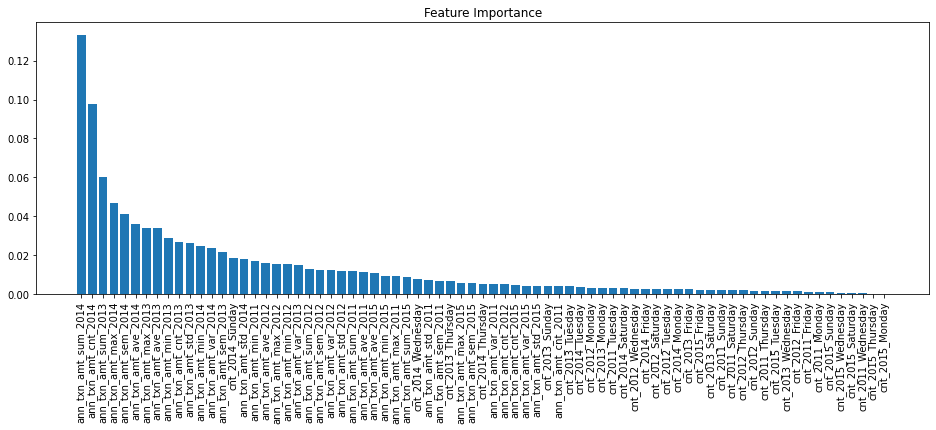

In [42]:

best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_annual, X_test_annual, y_train_annual, y_test_annual, X_train_annual,5)

<Figure size 720x576 with 0 Axes>

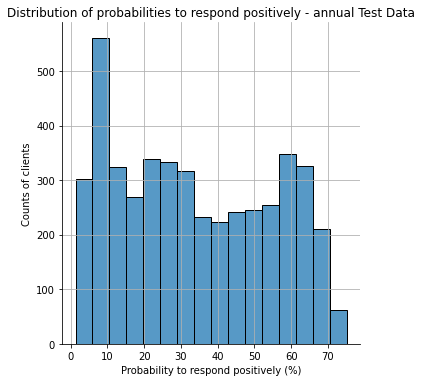

In [43]:
fig = plt.figure(figsize= (10,8))
sns.displot(data = y_test_prob[:,1], x = 100*y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively - annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.grid()
plt.show()

Precision: 0.2052469135802469
Recall 0.5898004434589801


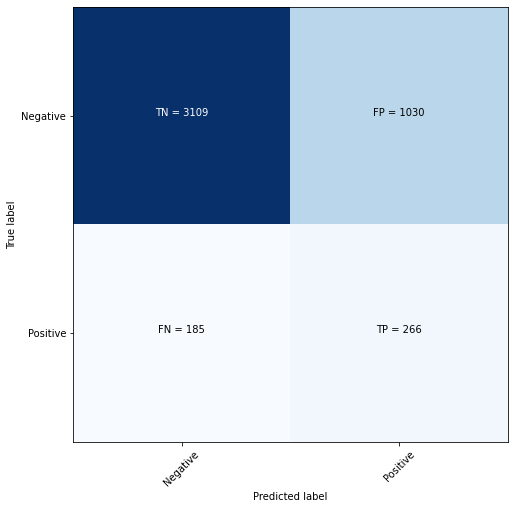

In [44]:
plot_confusion_matrix(y_test_annual.values, y_test_pred)

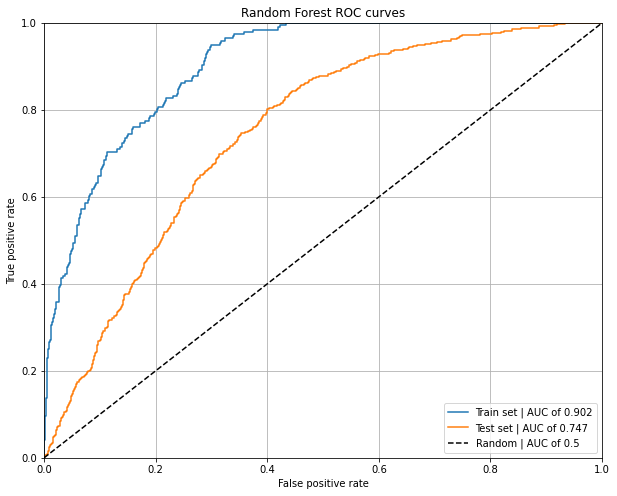

In [45]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Random Forest')

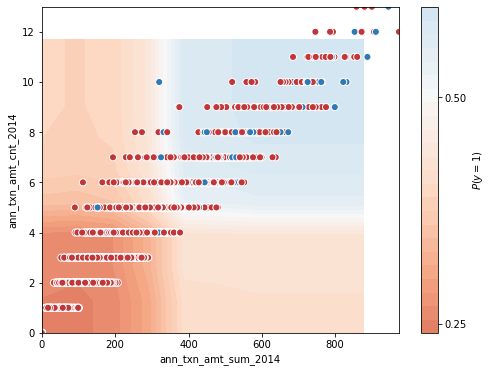

In [46]:
plot_decision_boundary(best_model, 33, 8, X_train_annual.values, X_train_annual, y_train_annual)

## Monthly Features

> **1.** Separate the inputs X and the output y in two data frames.

In [47]:
X_mth = mth_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
X_mth.head()

,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,...,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn
0,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,-5
1,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,1,15
2,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,46
3,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,0,0,12
4,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,42


In [48]:
y_mth = mth_features_outputs['response']
y_mth.head()

0    0
1    0
2    0
3    0
4    0
Name: response, dtype: int64

> **2.** Split the data in train and test set.

In [49]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_mth, y_mth, 
                                                                                    test_size=2/3, 
                                                                                    random_state=1147)

> **3.** Pre-process (if necessary for the method).

In [50]:
scaler_monthly = StandardScaler()

X_train_monthly_scaled = scaler_monthly.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler_monthly.transform(X_test_monthly)

X_train_monthly_scaled,X_test_monthly_scaled

(array([[-0.57802857, -0.61910376,  0.38146405, ..., -0.23577711,
         -0.23597749,  0.24405433],
        [-0.57802857, -0.61910376, -0.46140424, ..., -0.23577711,
         -0.23597749, -0.43307757],
        [-0.57802857, -0.61910376, -0.93392132, ..., -0.23577711,
         -0.23597749,  1.70249228],
        ...,
        [ 0.13653326,  0.98297224, -0.53802863, ..., -0.23577711,
         -0.23597749, -0.84977413],
        [ 0.48228899,  0.98297224,  0.26652746, ..., -0.23577711,
         -0.23597749, -0.84977413],
        [ 6.95944627,  5.78920022,  4.32762016, ...,  3.9924114 ,
          3.96576203, -0.83675236]]),
 array([[-0.57802857, -0.61910376,  1.23710308, ..., -0.23577711,
         -0.23597749, -0.3809905 ],
        [ 0.3439867 ,  0.98297224,  0.39423478, ..., -0.23577711,
          3.96576203, -0.77164352],
        [-0.57802857, -0.61910376, -0.14213595, ..., -0.23577711,
         -0.23597749, -0.32890343],
        ...,
        [-0.11702094,  0.98297224, -0.67850668, ..., -

### L1 log-reg

In [51]:
lr_performance_monthly = find_best_lr(X_train_monthly_scaled, y_train_monthly, X_test_monthly_scaled, y_test_monthly)

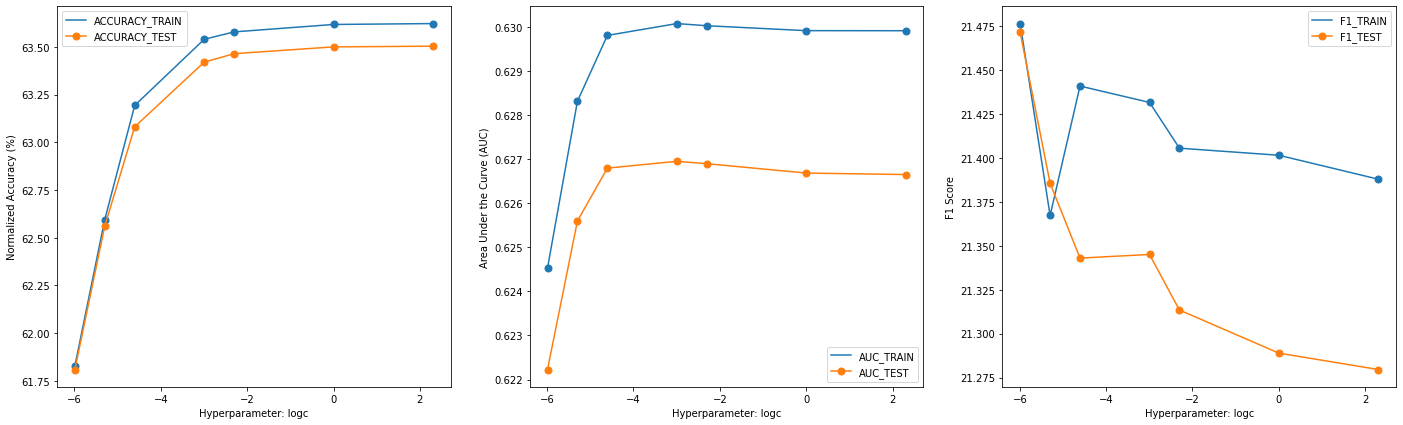

In [52]:
lr_performance_monthly['logc'] = np.log(lr_performance_monthly['C'])
plot_train_test_curves(lr_performance_monthly,'logc')

In [53]:
lr_performance_monthly

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,logc
0,0.0025,61.826257,61.808353,21.476254,21.471264,0.133119,0.554724,0.624527,0.622228,-5.991465
1,0.0050,62.594924,62.560791,21.367172,21.385460,0.133265,0.541030,0.628311,0.625596,-5.298317
2,0.0100,63.192983,63.080960,21.440728,21.342921,0.133482,0.532164,0.629803,0.626794,-4.605170
3,0.0500,63.539764,63.420322,21.431426,21.344977,0.133805,0.527337,0.630071,0.626948,-2.995732
4,0.1000,63.578707,63.464365,21.405418,21.313391,0.133661,0.525712,0.630022,0.626895,-2.302585
5,1.0000,63.617651,63.500063,21.401386,21.288891,0.133552,0.524431,0.629911,0.626682,0.000000
6,10.0000,63.622287,63.503771,21.387781,21.279574,0.133501,0.524086,0.629909,0.626648,2.302585


    Auc test virtually stays the same. F1 test results tend to be higher when C is between 0.01 and 0.05. I select C = 0.05 based on test accuracy and F1 scores.

The indices for top 2 features are: 15:amt_mean_12M, 14:amt_sum_12M 


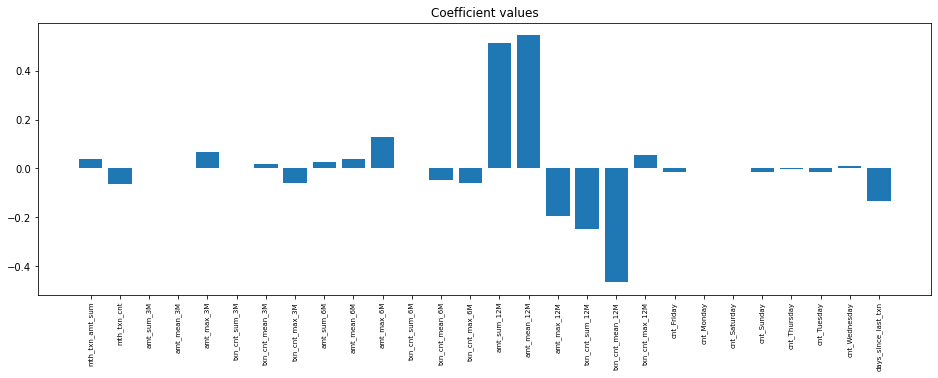

In [54]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, X_train_monthly, 0.05)

<Figure size 720x576 with 0 Axes>

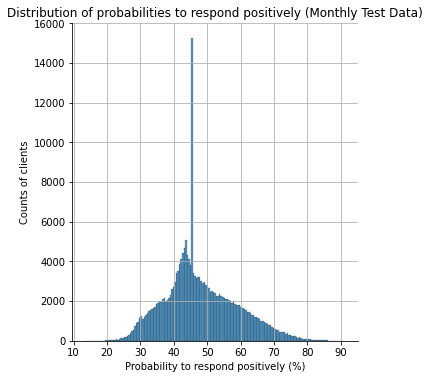

In [55]:
fig = plt.figure(figsize= (10,8))
sns.displot(data = y_test_prob[:,1], x = 100 * y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively (Monthly Test Data)')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.grid()
plt.show()

Precision: 0.1338049292606109
Recall 0.5273372081568318


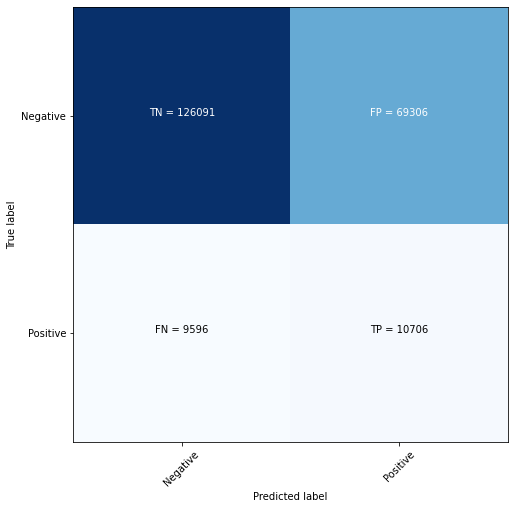

In [56]:
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

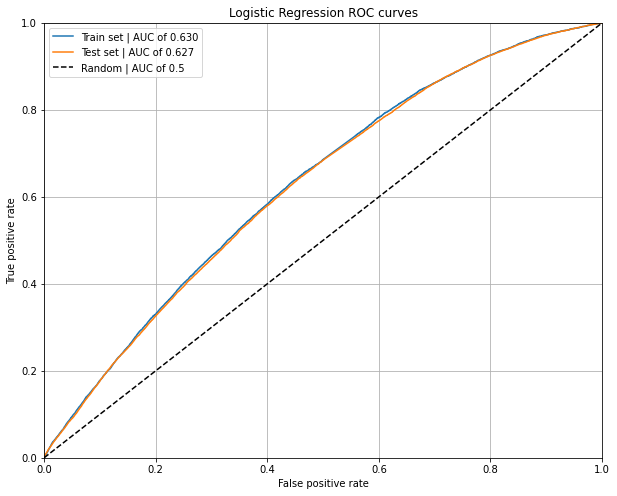

In [57]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Logistic Regression')

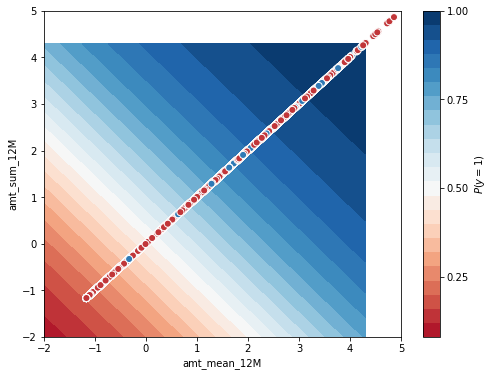

In [58]:
plot_decision_boundary(best_model, 15, 14, X_train_monthly_scaled, X_train_monthly, y_train_monthly)

### Decision Tree

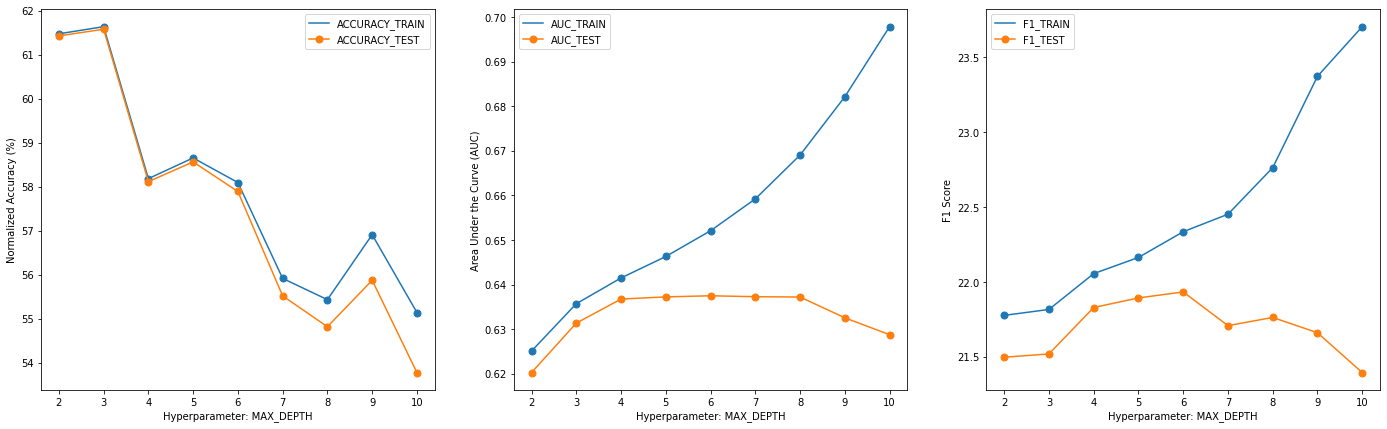

In [59]:
dt_performance_monthly = find_best_dt(X_train_monthly, y_train_monthly, X_test_monthly, y_test_monthly)
plot_train_test_curves(dt_performance_monthly,'MAX_DEPTH')

In [60]:
dt_performance_monthly

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,61.472058,61.424485,21.777108,21.497646,0.132954,0.561176,0.625082,0.620261
1,3,61.634322,61.576085,21.816601,21.519611,0.133206,0.559699,0.635699,0.631349
2,4,58.182273,58.114317,22.055926,21.829603,0.132406,0.621367,0.641477,0.636744
3,5,58.652375,58.562163,22.164040,21.893651,0.133078,0.617033,0.646289,0.637231
4,6,58.093260,57.889930,22.335636,21.933632,0.132849,0.628510,0.652061,0.637487
5,7,55.915215,55.518106,22.452741,21.708513,0.130094,0.655206,0.659198,0.637274
6,8,55.433059,54.817593,22.763574,21.763214,0.130004,0.667668,0.669029,0.637204
7,9,56.909197,55.873231,23.373840,21.661084,0.130033,0.648163,0.682099,0.632549
8,10,55.140984,53.775864,23.705292,21.394953,0.127359,0.668358,0.697814,0.628757


    When max depth is between 4 and 6, F1 scores are comparatively high. When max depth is set to 5, accuracy is better for numbers 4 to 6. I therefore select max depth = 5 here.

The indices for top 2 features are: 15:amt_mean_12M, 16:amt_max_12M 


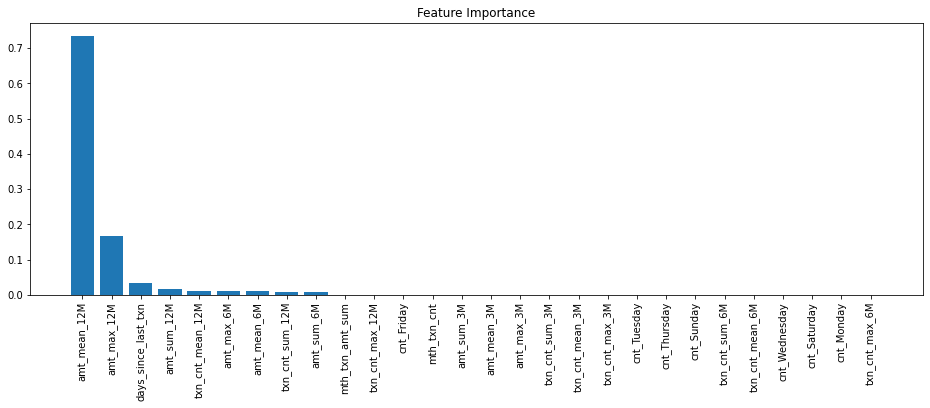

In [61]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly, X_train_monthly,5)

Text(0, 0.5, 'Counts of clients')

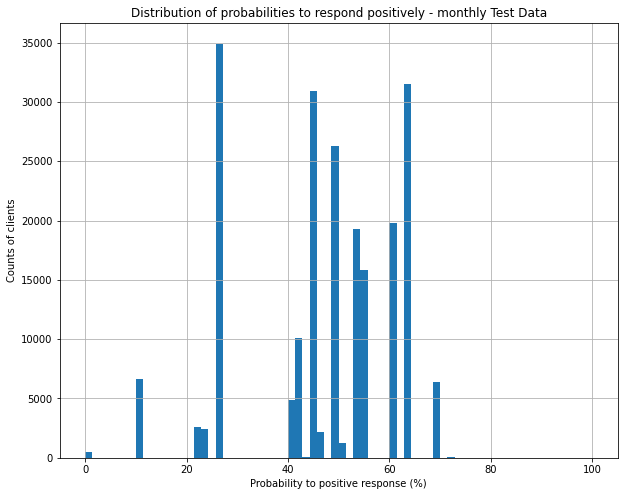

In [62]:
fig = plt.figure(figsize= (10,8))
plt.hist(100*y_test_prob[:,1], bins=70)
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to positive response (%)')
plt.grid()
plt.ylabel('Counts of clients')

Precision: 0.13307766670561866
Recall 0.6170328046497882


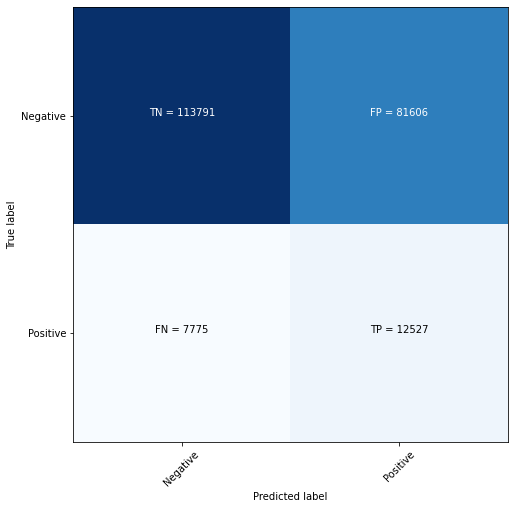

In [63]:
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

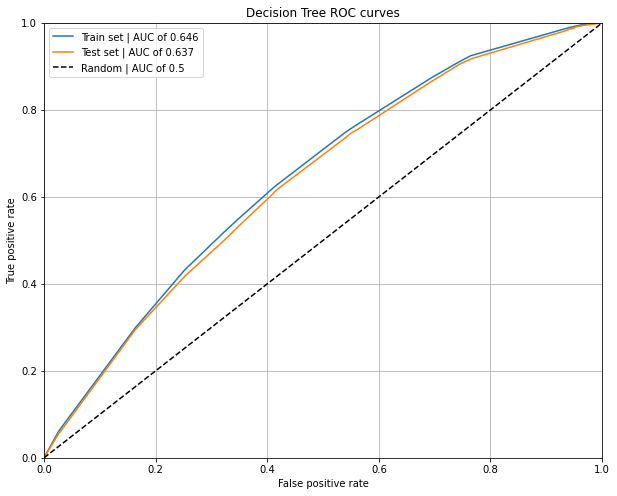

In [64]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Decision Tree')

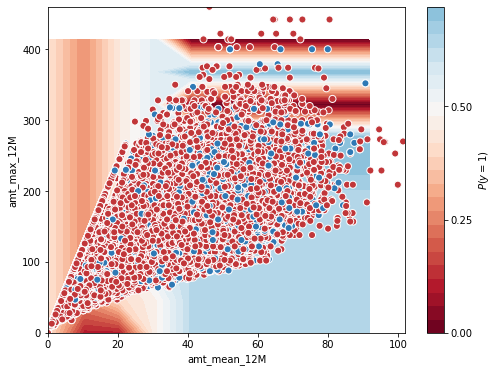

In [65]:
plot_decision_boundary(best_model, 15, 16, X_train_monthly.values, X_train_monthly, y_train_monthly)

### Random Forest

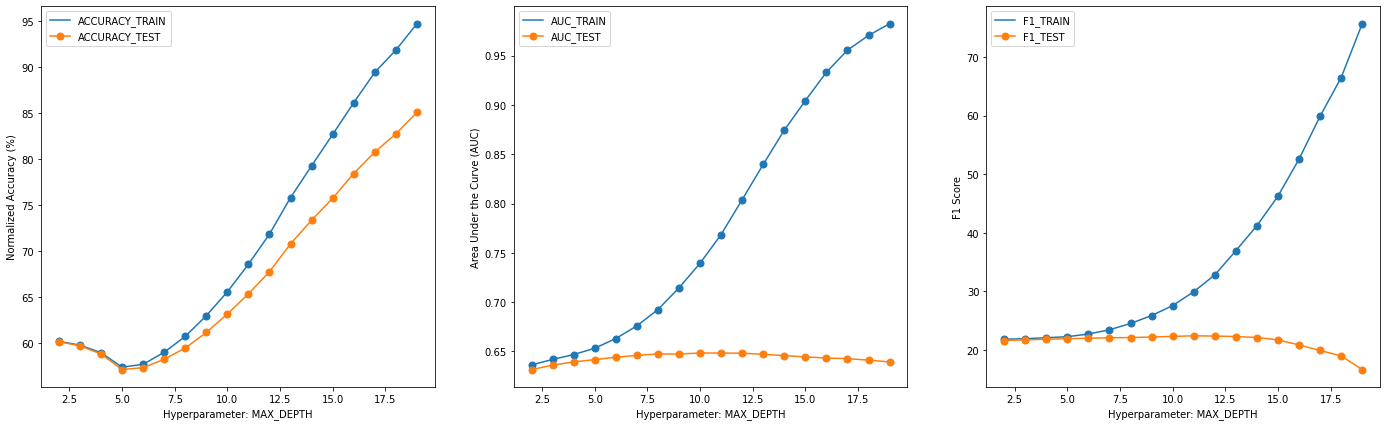

In [66]:
rf_performance_monthly = find_best_rf(X_train_monthly, y_train_monthly, X_test_monthly, y_test_monthly)
plot_train_test_curves(rf_performance_monthly,'MAX_DEPTH')

In [67]:
rf_performance_monthly

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.219381,60.171350,21.848188,21.626405,0.132712,0.583834,0.636381,0.631647
1,3,59.811403,59.741121,21.931231,21.736544,0.133022,0.593981,0.641953,0.636168
2,4,58.996375,58.848210,22.097735,21.839283,0.132967,0.610827,0.646878,0.639419
3,5,57.419169,57.154646,22.276381,21.935211,0.132378,0.639543,0.653305,0.641742
4,6,57.727007,57.367443,22.728428,22.016621,0.132978,0.639395,0.663123,0.644188
5,7,59.035318,58.277507,23.460726,22.093718,0.134023,0.628559,0.675961,0.646027
6,8,60.760879,59.494944,24.528739,22.133098,0.135113,0.611615,0.692507,0.647557
7,9,62.999193,61.179236,25.889126,22.217475,0.136906,0.589055,0.714459,0.647398
8,10,65.590780,63.187127,27.576112,22.323306,0.139277,0.562014,0.739450,0.648475
9,11,68.580144,65.369798,29.952869,22.427383,0.142096,0.531869,0.768543,0.648427


    With an increase in max depth, accuracy rises. For the test set, the AC curve virtually stays the same. F1 scores tend to be higher when max depth is between 6 and 14. I decide on max depth = 14 based on the accuracy and F1 score.

The indices for top 2 features are: 14:amt_sum_12M, 15:amt_mean_12M


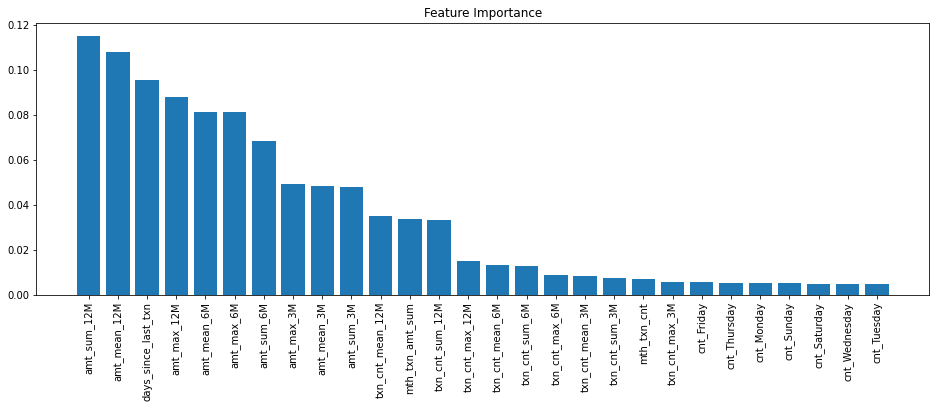

In [68]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly, X_train_monthly,14)

Text(0, 0.5, 'Counts of clients')

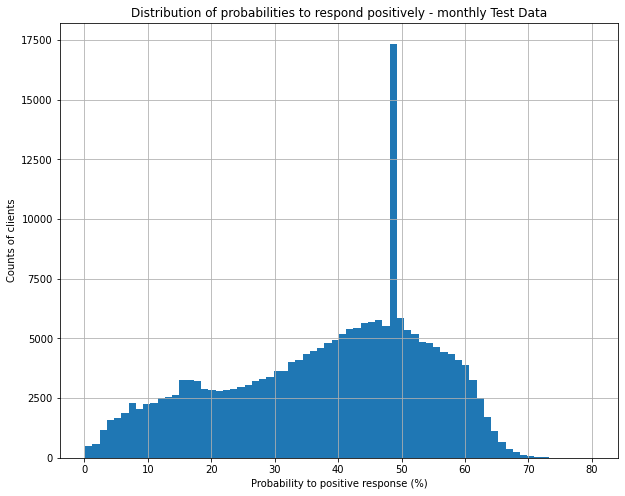

In [69]:
fig = plt.figure(figsize= (10,8))
plt.hist(100*y_test_prob[:,1], bins=70)
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to positive response (%)')
plt.grid()
plt.ylabel('Counts of clients')

Precision: 0.15268845348489382
Recall 0.4022756378681903


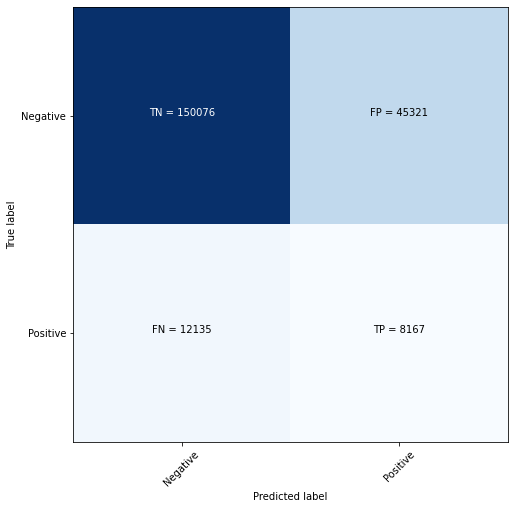

In [70]:
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

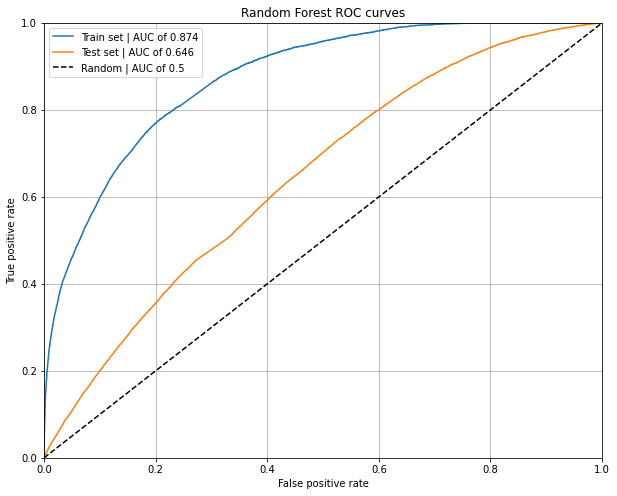

In [71]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Random Forest')

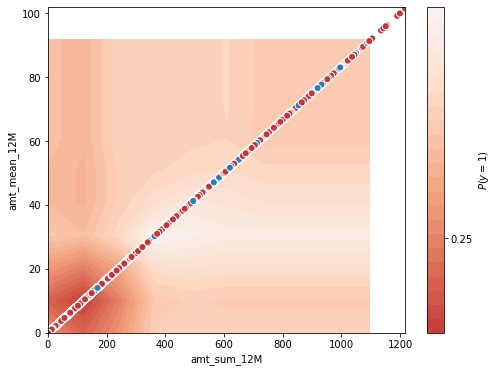

In [72]:
plot_decision_boundary(best_model, 14, 15, X_train_monthly.values, X_train_monthly, y_train_monthly)

## 1.3 Comparison of methods (10 points)
> Compare the two feature engineering (annual and monthly) and the three modeling ap- proaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. Which combina- tion of feature engineering and modeling approach do you select as the best to deploy in a production environment and why? **Tabularize** your findings in steps 5-8 to summarize the results and support your decision (how to organize information with tables in Markdown).


####  <center>Annual Dataset (%)</div></center>
|Model|precision|recall|Test Accuracy|Testing AUC|Training AUC|
|----------- |----------- |----------- |----------- |----------- |----------- |
|L1 lr|20.35|66.55|71.08|81.18|75.77|
|Tree|19.99|65.89|70.42|78.44|74.18|
|Forests|20.54|59.07|73.62|90.17|74.76|

####  <center>Monthly Dataset(%)</div></center>
|Model|precision|recall|Test Accuracy|Testing AUC|Training AUC|
| ----------- |----------- |----------- |----------- |----------- |----------- |
|L1 lr|13.42|52.7|63.44|63.03|62.77|
|Tree|13.33|61.69|58.5|64.61|63.69|
|Forests|15.35|40.17|73.4|87.32|64.58|

    All measures' monthly feature scores are lower than their annual feature scores. The fact that monthly data has many more records and fewer features than annual data, as seen in the above tables, may be one of the causes. As a result, the models might not have learned enough from the data.


#### <b>Comparing two feature engineering methods</b>: 
<b>Metrics</b>:

    All measures' monthly feature scores are lower than their annual feature scores. The fact that monthly data has more records and fewer features than annual data, as shown in the above tables, may be one of the causes. As a result, the models might not have learned enough information from the data. To address this issue, more features could be added to monthly data, which would increase the predictive power of the models.

<b>Top 2 features</b>

    By examining the top two features, it is evident that all models favour long-term indicators such as annual sums, means, and counts of all transactions in annual models and sums, means, and maximums of transactions over 12-month periods. This makes a lot of sense because the models have successfully captured the long-term trend and won't be significantly impacted by outliers present in short-term indicators.

<b>Number of Important Features</b>

    By comparing the total number of features in two distinct datasets with the amount of relevant features in each, it is evident that the yearly dataset can employ fewer characteristics to achieve better performance because annual models have a lower percentage of important features than the monthly model.

<b>Distribution</b>

    The trend of all the distributions are very similar, logistic regression model has left skewed structure all the time and tree models are right skewed. However, by looking at the x-axis scales, it clearly shows that the annual models have larger probabilities in predicting positive responses such as logistic regression: the maximum probability from it using annual data is nearly 100% and minimum is 0% but monthly model has a range of 20%-90% which indicates annual data make the models more confident to predict the positive classes.

<b>Confusion Matrix</b>

    By comparing the number of true predictions to the number of false predictions, we can see that the ratio between the two is roughly 4 for annual data and 6 for monthly data, meaning that annual data has more true predictions and fewer false predictions.

#### <b>Comparing three models</b>:
<b>Metrics</b>:

    According to the tables above, random forest has the best performance metrics for both annual and monthly data, and it has the fewest FALSE POSITIVES when compared to the other two models.

<b>Features</b>

    Given its ability to dig really deep and combine multiple simple trees into a single final prediction, random forest has a significant advantage over logistic regression and decision trees in terms of information extraction. These two methods only used a small number of features and viewed the majority of the features as being unnecessary, which could be a waste of information.

<b>Confusion Matrix</b>

    In terms of TP, decision tree surpasses the other two models in monthly data while logistic regression performs best in annual data with the highest test AUC score, recall, and number of TRUE POSITIVE predictions.

<b>Distribution</b>

    In terms of test result distributions, decision tree has the sparse structure due to its nature and logistics regression is always left skewed which means most of its predictions are below 50% (class 0), however, random forest is opposite to logistic regression model which is more evenly distributed and a little bit right skewed which mean it predicted a lot of class 1 in the test data.
    

#### Find the best model 
    The major goal of a promotion campaign is to raise the ROI (return on investment) of the promotion activity, which means that we want to interact more with the customers that responded favourably because we want them to do additional transactions, which will increase our ROI. we wish to decrease the number of persons whose responses were positive but were misinterpreted as negative by the model. The cost of FN is actually very high because we will miss the chance to interact with customers who are actually interested in our marketing campaign. On the other hand, it doesn't really matter if we believe some customers aren't interested in our campaign. In order to ensure that every client who is truly interested will be engaged and accurately identified by our model, we are concentrating more on the recall of the model. In contrast to being influenced by minor fluctuations and outliers in monthly data, annual data may help us better understand the overall profile of all clients, and models may be more confidently able to estimate the probability of the classes. We may have better confidence in engaging with the proper clients and generating a higher ROI from this advertising campaign because logistic regression on annual data provides us with the best recall, AUC test socre, and largest number of true positives.